In [5]:
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive/DL/ECG"  # check files in dir
#!kill -9 -1                       # clear memory
#!cat /proc/meminfo                # check memoery used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

plt.style.use('seaborn-whitegrid')
pd.set_option("display.max_columns",101)
%matplotlib inline

import os

import time
import pickle
import gc

import tensorflow as tf
from sklearn.model_selection import train_test_split

!pip install -U tensorboardcolab
from tensorboardcolab import *
import shutil

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


# Define Functions

In [0]:
## One-hot encoding
def one_hot(labels, n_class = 4):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:,labels-1].T
    return y

## Standardize
def standardize(X):
    """ Standardize by mean and std for each measurement channel"""
    return (X - np.mean(X, axis=0)[None,:,:]) / np.std(X, axis=0)[None,:,:]

## Get batches
def get_batches(X, y, batch_size = 100):
    """ Yield batches ffrom data """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

## Compute precision / recall / F1-Score / Accuracy within each class
def accuracy_train(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
  
def f1_score(label, confusion_matrix):
    prec = precision(label, confusion_matrix)
    rec = recall(label, confusion_matrix)
    return 2*prec*rec/(prec+rec)
  
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows
  
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

# Data Pre-processing

In [8]:
channel_name = 'ECG'
X = np.load('drive/My Drive/DL/'+ channel_name+'/ECGdata.npy')
Y = np.load('drive/My Drive/DL/'+ channel_name+'/ECGdata.npy')

print('X shape:', X.shape)
print('*'*50)
X_tr, X_test, Y_tr, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=2018)
del X
del Y
gc.collect()

# Standardize
X_tr = standardize(X_tr); X_test = standardize(X_test)

print('X_tr shape:', X_tr.shape)
print('*'*50)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr, Y_tr, test_size=0.2, stratify=Y_tr, random_state=2018)

# One-hot encode
y_train = one_hot(Y_train, n_class=4) 
y_valid = one_hot(Y_valid, n_class=4)
y_test = one_hot(Y_test, n_class=4)

print("Training set size: ", len(X_train))
print("Training Number of instances: ", X_train.shape[0])
print("Training Length of sequence: ", X_train.shape[1])
print("Training Number of channels: ", X_train.shape[2])
print('*'*50)
print("X_valid set size: ", len(X_valid))
print("X_valid Number of instances: ", X_valid.shape[0])
print("X_valid Length of sequence: ", X_valid.shape[1])
print("X_valid Number of channels: ", X_valid.shape[2])
print('*'*50)
print("X_valid set size: ", len(X_test))
print("X_valid Number of instances: ", X_test.shape[0])
print("X_valid Length of sequence: ", X_test.shape[1])
print("X_valid Number of channels: ", X_test.shape[2])

X shape: (21393, 15360, 2)
**************************************************
X_tr shape: (17114, 15360, 2)
**************************************************
Training set size:  13691
Training Number of instances:  13691
Training Length of sequence:  15360
Training Number of channels:  2
**************************************************
X_valid set size:  3423
X_valid Number of instances:  3423
X_valid Length of sequence:  15360
X_valid Number of channels:  2
**************************************************
X_valid set size:  4279
X_valid Number of instances:  4279
X_valid Length of sequence:  15360
X_valid Number of channels:  2


In [0]:
# clean out the directory
shutil.rmtree('./graph', ignore_errors=True)
os.mkdir('./graph')

# start the tunneling and print out a link:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://470bfe0a.ngrok.io


# Build Tensorflow Computing Graph

In [9]:
# Hyperparameters
batch_size = 256       
seq_len = 15360       
learning_rate = 0.0001
epochs = 50

n_classes = 4
n_channels = 2

# Placeholders
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')
    
# Now, build the covolutional layers:
with graph.as_default():
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=46, kernel_size=4, strides=2, 
                             padding='valid', activation = tf.nn.relu)
    print(conv1.get_shape())
    
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=4, strides=2, padding='valid')
    print(max_pool_1.get_shape())
    
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=92, kernel_size=4, strides=2, 
                             padding='valid', activation = tf.nn.relu)
    print(conv2.get_shape())
    
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=4, strides=2, padding='valid')
    print(max_pool_2.get_shape())
    
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=184, kernel_size=10, strides=2, 
                             padding='valid', activation = tf.nn.relu)
    print(conv3.get_shape())
    
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=10, strides=5, padding='valid')
    print(max_pool_3.get_shape())
    
# Flatten and pass to the classifier
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_3, (-1, 94*184))
    flat_dp = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat_dp, n_classes)
    
    # metrics, save y_p values to compute recall, precision, f1-score
    y_p = tf.argmax(logits, 1)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    #with tf.name_scope('logit'):
    #    tf.summary.scalar('Logits', logits)

    
#summaries = tf.summary.merge_all()
#train_writer = tbc.get_writer()

Instructions for updating:
Use keras.layers.conv1d instead.
Instructions for updating:
Colocations handled automatically by placer.
(?, 7679, 46)
Instructions for updating:
Use keras.layers.max_pooling1d instead.
(?, 3838, 46)
(?, 1918, 92)
(?, 958, 92)
(?, 475, 184)
(?, 94, 184)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Train CNN Models

In [10]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

train_recall = []
train_precision = []
train_f1 = []

validation_recall = []
validation_precision = []
validation_f1 = []

train_confusion_matrix = np.zeros((4,4))

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            #summaries, loss, _ , acc, y_pred = sess.run([summaries, cost, optimizer, accuracy, y_p], feed_dict = feed)
            loss, _ , acc, y_pred = sess.run([cost, optimizer, accuracy, y_p], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            recall_t = sk.metrics.recall_score(np.argmax(y, 1), y_pred, average=None)
            train_recall.append(recall_t)
            
            precision_t = sk.metrics.precision_score(np.argmax(y, 1), y_pred, average=None)
            train_precision.append(precision_t)
            
            f1_t = sk.metrics.f1_score(np.argmax(y, 1), y_pred, average=None)
            train_f1.append(f1_t)
            
            # Print at each 20 iters
            if (iteration % 20 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "-> Train loss: {:6f}".format(loss),
                      "| Train acc: {:.6f}".format(acc),
                      #"| Train Recall: {}".format(np.mean(train_recall, axis=0)),
                      #"| Train Precision: {}".format(np.mean(train_precision, axis=0)),
                      "| Train f1-score: {}".format(np.mean(train_f1, axis=0)))
                
                #train_writer.add_summary(summaries, iteration)
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                val_recall_ = []
                val_precision_ = []
                val_f1_ = []
                
                for x_v, y_v in get_batches(X_valid, y_valid, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v, y_pred_v = sess.run([cost, accuracy, y_p], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                    
                    recall_v = sk.metrics.recall_score(np.argmax(y_v, 1), y_pred_v, average=None)
                    val_recall_.append(recall_v)
                
                    precision_v = sk.metrics.precision_score(np.argmax(y_v, 1), y_pred_v, average=None)
                    val_precision_.append(precision_v)
                    
                    f1_v = sk.metrics.f1_score(np.argmax(y_v, 1), y_pred_v, average=None)
                    val_f1_.append(f1_v)
                    
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "-> Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)),
                      #"Validation Recall: {}".format(np.mean(val_recall_,axis=0)),
                      #"Validation Precision: {}".format(np.mean(val_precision_,axis=0)),
                      "Validation f1-score: {}".format(np.mean(val_f1_,axis=0)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))     
                validation_recall.append(np.mean(val_recall_, axis=0))
                validation_precision.append(np.mean(val_precision_, axis=0))
                
            # Iterate 
            iteration += 1

            if e == epochs-1:
                train_confusion_matrix = train_confusion_matrix + sk.metrics.confusion_matrix(np.argmax(y, 1), y_pred)
            
    print(train_confusion_matrix.astype(int))  
    
    for label in range(4):
        print(f' Level:{label}  Accuracy:{accuracy_train(train_confusion_matrix):.4f}   Precision:{precision(label, train_confusion_matrix):.4f} \
                Recall:{recall(label, train_confusion_matrix):.4f}   F1-Score:{f1_score(label, train_confusion_matrix):.4f}')

    saver.save(sess,'drive/My Drive/DL/'+ channel_name+'/ccsh.ckpt')
    sess.close()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 0/50 Iteration: 10 -> Validation loss: 1.361057 Validation acc: 0.255409 Validation f1-score: [0.         0.05786922 0.40041536 0.00473373]
Epoch: 0/50 Iteration: 20 -> Train loss: 1.327912 | Train acc: 0.320312 | Train f1-score: [0.15091243 0.28584695 0.34628555 0.21026687]
Epoch: 0/50 Iteration: 20 -> Validation loss: 1.322669 Validation acc: 0.420072 Validation f1-score: [0.37209361 0.48653884 0.31448008 0.41541622]
Epoch: 0/50 Iteration: 30 -> Validation loss: 1.284822 Validation acc: 0.433293 Validation f1-score: [0.20119642 0.52956106 0.47320057 0.39216001]
Epoch: 0/50 Iteration: 40 -> Train loss: 1.276470 | Train acc: 0.441406 | Train f1-score: [0.2300464  0.37680057 0.37642929 0.26564401]
Epoch: 0/50 Iteration: 40 -> Validation loss: 1.244475 Validation acc: 0.488882 Validation f1-score: [0.46529506 0.55790692 0.48929301 0.39400097]
Epoch: 0/50 Iteration: 50 -> Validation loss: 1.197699 Validation acc: 0.541466 Validation f1-score: [0.4786812  0.59894904 0.53743431 0.526

In [0]:
train_writer.add_graph(sess.graph)
train_writer.flush()
tbc.close()

## Plot the Recall Metrics for training and validation sets

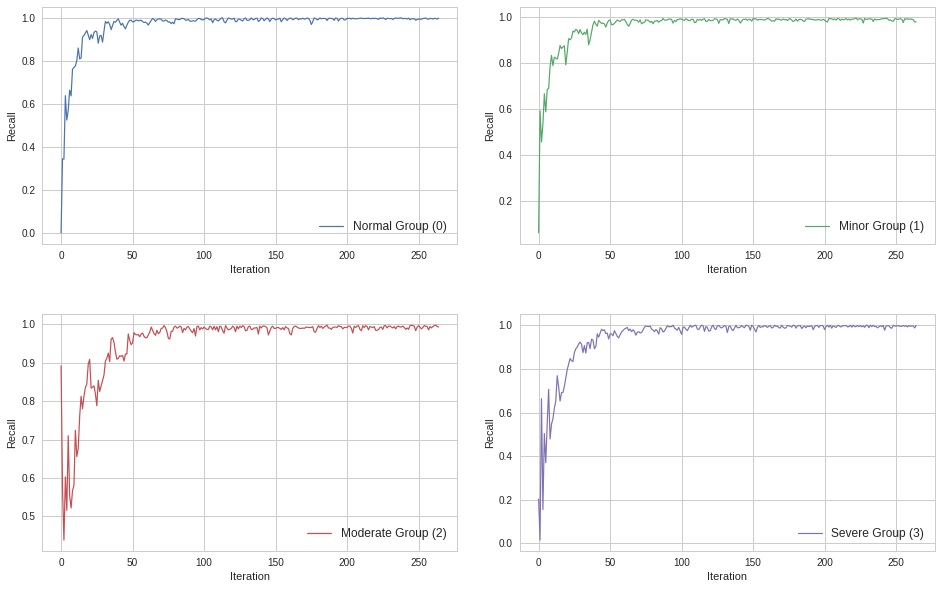

In [0]:
df_rec = pd.DataFrame(validation_recall).rename(columns={0: 'Normal Group (0)', 1: 'Minor Group (1)', 2: 'Moderate Group (2)', 3: 'Severe Group (3)'})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
plt.subplots_adjust(wspace=0.15, hspace=0.3);

axe_pos = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
df_rec.plot(subplots=True, ax=axe_pos, legend=True, sharex=False, sharey=False, linewidth=1.2)

[a.legend(fontsize=12, loc='lower right') for a in axe_pos]
[a.set_xlabel('Iteration') for a in axe_pos]
[a.set_ylabel('Recall') for a in axe_pos]

fig.savefig('drive/My Drive/DL/' + channel_name + '/validation_recall_12_01.png', dpi=fig.dpi)

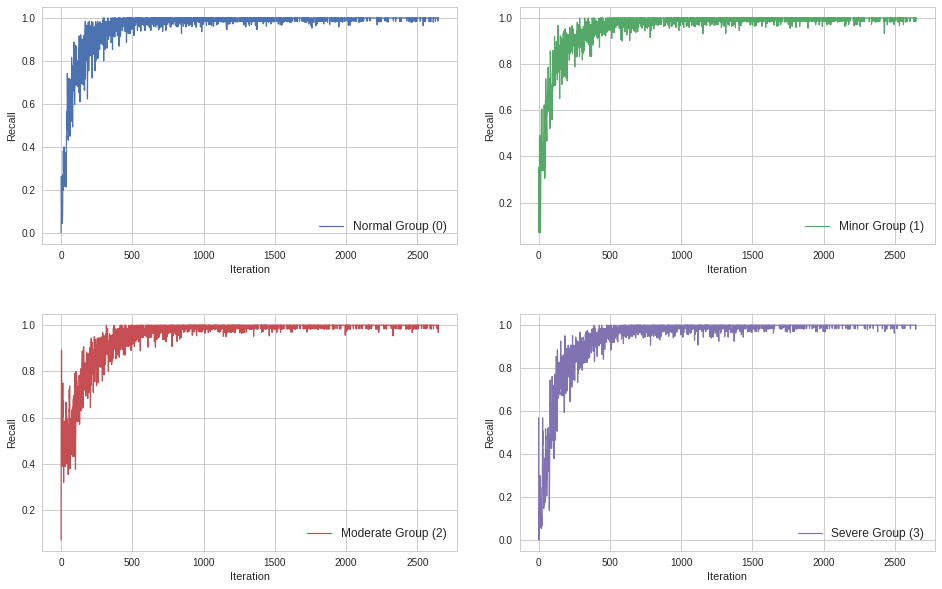

In [0]:
df_rec = pd.DataFrame(train_recall).rename(columns={0: 'Normal Group (0)', 1: 'Minor Group (1)', 2: 'Moderate Group (2)', 3: 'Severe Group (3)'})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
plt.subplots_adjust(wspace=0.15, hspace=0.3);

axe_pos = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
df_rec.plot(subplots=True, ax=axe_pos, legend=True, sharex=False, sharey=False, linewidth=1.2)

[a.legend(fontsize=12, loc='lower right') for a in axe_pos]
[a.set_xlabel('Iteration') for a in axe_pos]
[a.set_ylabel('Recall') for a in axe_pos]

fig.savefig('drive/My Drive/DL/' + channel_name + '/train_recall_12_01.png', dpi=fig.dpi)

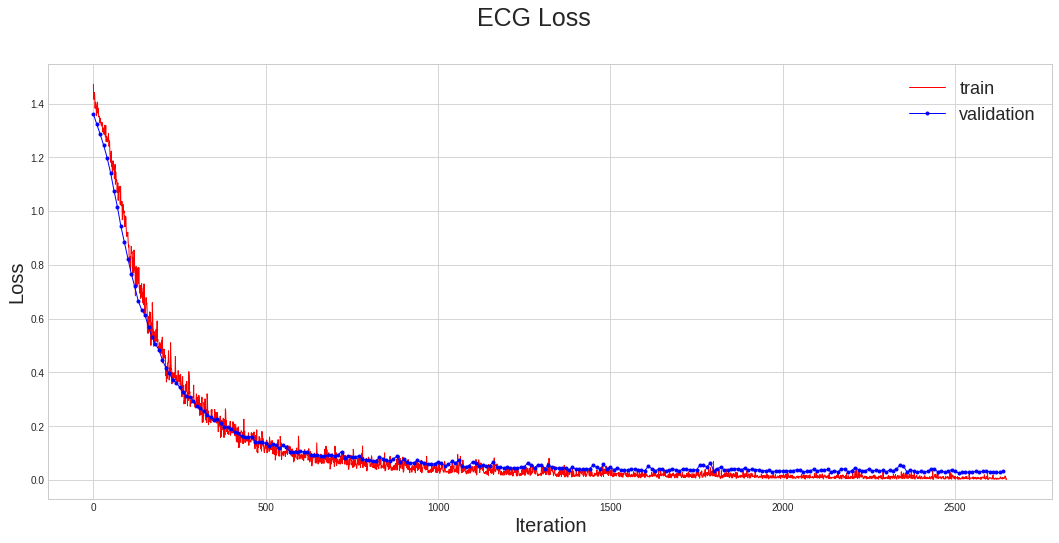

In [27]:
# Plot training and test loss  
t = np.arange(iteration-1)

fig = plt.figure(figsize = (18,8))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b-o', linewidth=1, markersize=3)
fig.suptitle('ECG Loss', fontsize=25)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(['train', 'validation'], loc='upper right', prop={'size': 18})
plt.show()


fig.savefig('drive/My Drive/DL/' + channel_name + '/loss_05_12.png', dpi=fig.dpi, transparent=True)

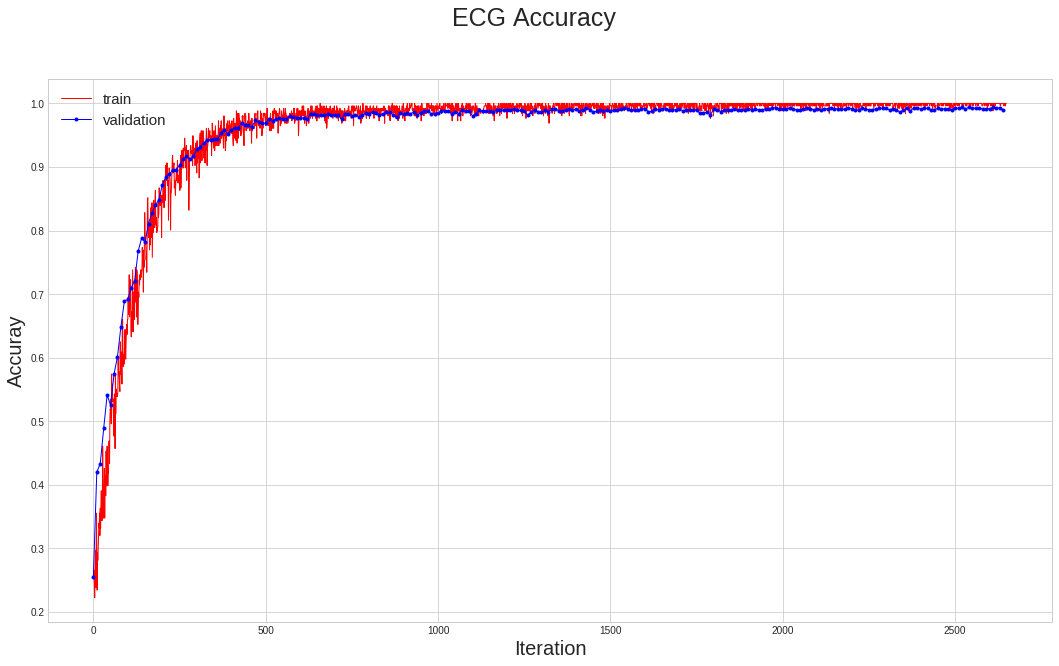

In [26]:
# Plot Accuracies
fig = plt.figure(figsize = (18,10))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b-o', linewidth=1, markersize=3)
fig.suptitle('ECG Accuracy', fontsize=25)
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("Accuray", fontsize=20)
plt.legend(['train', 'validation'], loc='upper left', prop={'size': 15})
plt.show()
fig.savefig('drive/My Drive/DL/' + channel_name + '/acc_05_12.png', dpi=fig.dpi, transparent=True)

# Test the CNN model with test set

In [0]:
test_acc = []
test_confusion_matrix = np.zeros((4,4))

with tf.Session(graph=graph) as sess:
  # Restore
  saver.restore(sess, tf.train.latest_checkpoint('drive/My Drive/DL/ECG'))
  
  for x_t, y_t in get_batches(X_test, y_test, batch_size):
    feed = {inputs_: x_t,
            labels_: y_t,
            keep_prob_: 1.0}
    
    batch_acc, y_pred_batch = sess.run([accuracy, y_p], feed_dict=feed)
    test_acc.append(batch_acc)
    test_confusion_matrix = test_confusion_matrix + sk.metrics.confusion_matrix(np.argmax(y_t, 1), y_pred_batch)
    
  print('Test accuracy: {:.6f}'.format(np.mean(test_acc)))
  print(test_confusion_matrix.astype(int))

INFO:tensorflow:Restoring parameters from drive/My Drive/DL/ECG/ccsh.ckpt
Test accuracy: 0.989746
[[1000    0    3    5]
 [  10 1032    6    8]
 [   1    0 1022    3]
 [   3    1    2 1000]]


In [0]:
for label in range(4):
    print(f' Level:{label}  Accuracy:{accuracy_train(test_confusion_matrix):.4f}    Precision:{precision(label, test_confusion_matrix):.4f} \
    Recall:{recall(label, test_confusion_matrix):.4f}    F1-Score:{f1_score(label, test_confusion_matrix):.4f}')

 Level:0  Accuracy:0.9897    Precision:0.9862     Recall:0.9921    F1-Score:0.9891
 Level:1  Accuracy:0.9897    Precision:0.9990     Recall:0.9773    F1-Score:0.9880
 Level:2  Accuracy:0.9897    Precision:0.9894     Recall:0.9961    F1-Score:0.9927
 Level:3  Accuracy:0.9897    Precision:0.9843     Recall:0.9940    F1-Score:0.9891
